# Part 3: Depth from Stereo

1. Write a program to estimate a depth map from a pair of calibrated images in Figure 4 using an MRF and graphcuts. 

In [25]:
import gco.pygco as pygco
import matplotlib.pyplot as plt
import numpy as np
import cv2

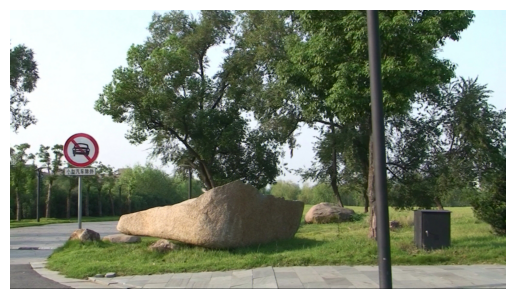

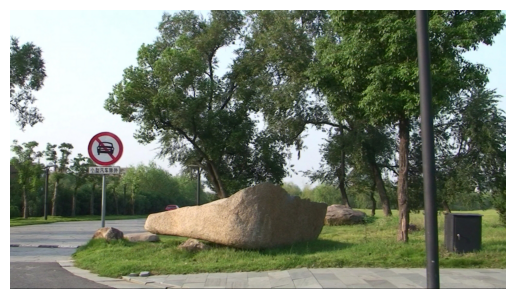

In [26]:
img1 = cv2.imread('part3_images/test00.jpeg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.axis('off')
plt.show()

img2 = cv2.imread('part3_images/test09.jpeg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img2)
plt.axis('off')
plt.show()

In [27]:
# load camera matrix
cam_matrix = np.loadtxt('cameras.txt', dtype=np.float32)
K1 = cam_matrix[0:3, 0:3]
R1 = cam_matrix[3:6, 0:3]
T1 = cam_matrix[6:7, 0:3]

K2 = cam_matrix[7:10, 0:3]
R2 = cam_matrix[10:13, 0:3]
T2 = cam_matrix[13:14, 0:3]

# height and width of the images
h1, w1 = img1.shape[:2]
h2, w2 = img2.shape[:2]

In [28]:
def compute_xInfinity(x, K1, R1, K2, R2):
        x_infinity = K2 @ R2.T @ R1 @ np.linalg.inv(K1) @ x
        return x_infinity

def compute_ePrime(T1, T2, K2, R2):
        e_prime = K2 @ R2.T @ (T1.T - T2.T)
        return e_prime

In [33]:
def dist(p1, p2):
    return (np.sum(np.abs(p1 - p2)**2) / 3) / 255


number_D = 50
disparity = np.linspace(0,0.01, number_D+1) # disparity candidates
# data term
data_term = np.zeros((h1, w1, number_D))

e_prime = compute_ePrime(T1=T1, T2=T2, K2=K2, R2=R2)



for y in range(h1):
    for x in range(w1):
        for d in range(number_D):
            x_h = np.array([x, y, 1])
            x_infinity = compute_xInfinity(x_h, K1=K1, R1=R1, K2=K2, R2=R2).reshape(3, 1)
            x_h_prime = x_infinity + disparity[d+1]*e_prime
            x_h_prime = x_h_prime * (1.0 / x_h_prime[2]) # normalize 
            
            # Whether the x_h_prime in the image2
            if(x_h_prime[0]<0):
                x_h_prime[0] = 0
            else:
                x_h_prime[0] = min(x_h_prime[0], w2-1)
            
            if(x_h_prime[1]<0):
                x_h_prime[1] = 0
            else:
                x_h_prime[1] = min(x_h_prime[1], h1-1)
            
            x_h_prime = x_h_prime.astype(int)
            #
            p1 = img1[y,x]
            p2 = img2[x_h_prime[1], x_h_prime[0]]
            data_term[y][x][d] = dist(p1, p2)

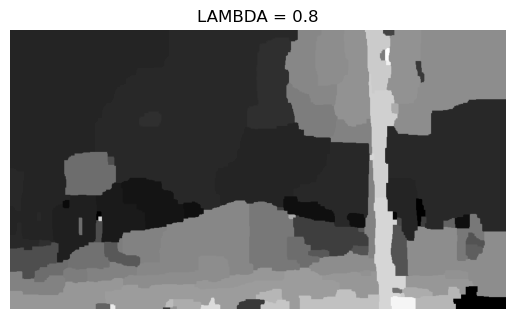

In [34]:
prior_matrix = 1 - np.eye(number_D)

LAMBDA = 0.8
labels = pygco.cut_grid_graph_simple(data_term, LAMBDA * prior_matrix, n_iter=-1, algorithm= 'swap')
labels = labels.reshape(h1, w1)

plt.imshow(labels, cmap='gray')
plt.title(f'LAMBDA = {LAMBDA}')
plt.axis('off')
plt.show()

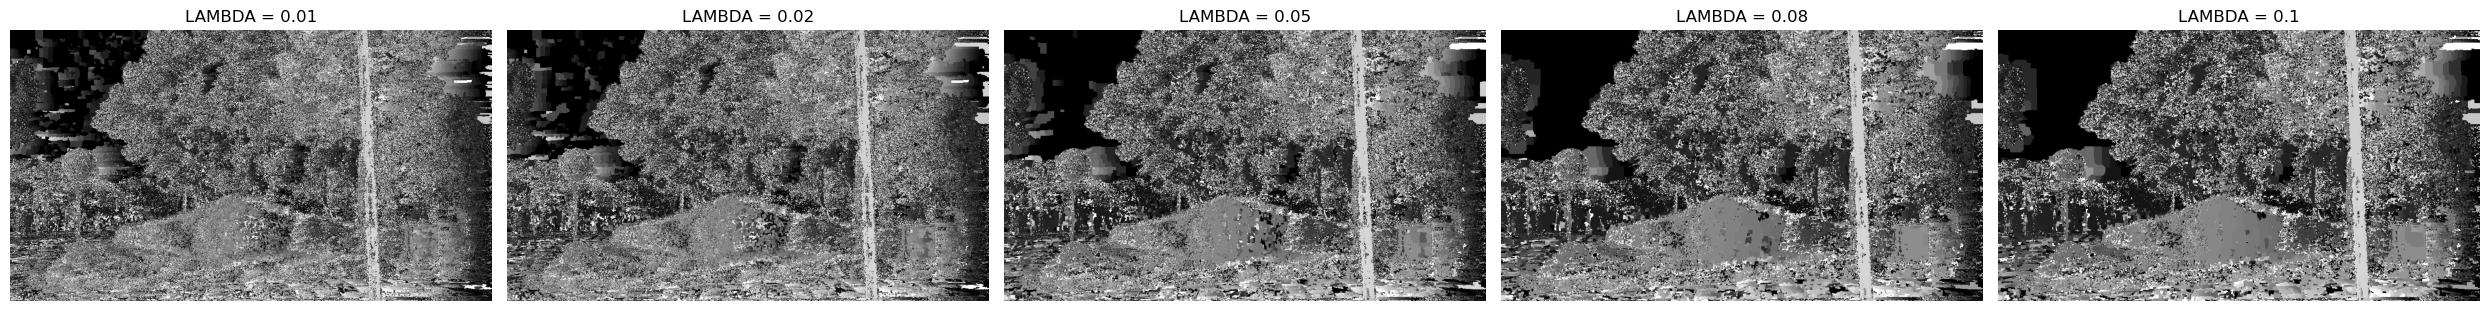

In [35]:
# Try different values of LAMBDA
LAMBDA_s =[0.01, 0.02, 0.05, 0.08, 0.1]

num_cols = len(LAMBDA_s)
fig, axes = plt.subplots(1, num_cols, figsize=(5*num_cols, 5))

for i, LAMBDA in enumerate(LAMBDA_s):
    labels = pygco.cut_grid_graph_simple(data_term, LAMBDA * prior_matrix, n_iter=-1, algorithm='swap')
    labels = labels.reshape(h1, w1)

    ax = axes[i]
    ax.imshow(labels, cmap='gray')
    ax.set_title(f'LAMBDA = {LAMBDA}')
    ax.axis('off')

plt.tight_layout()
plt.show()

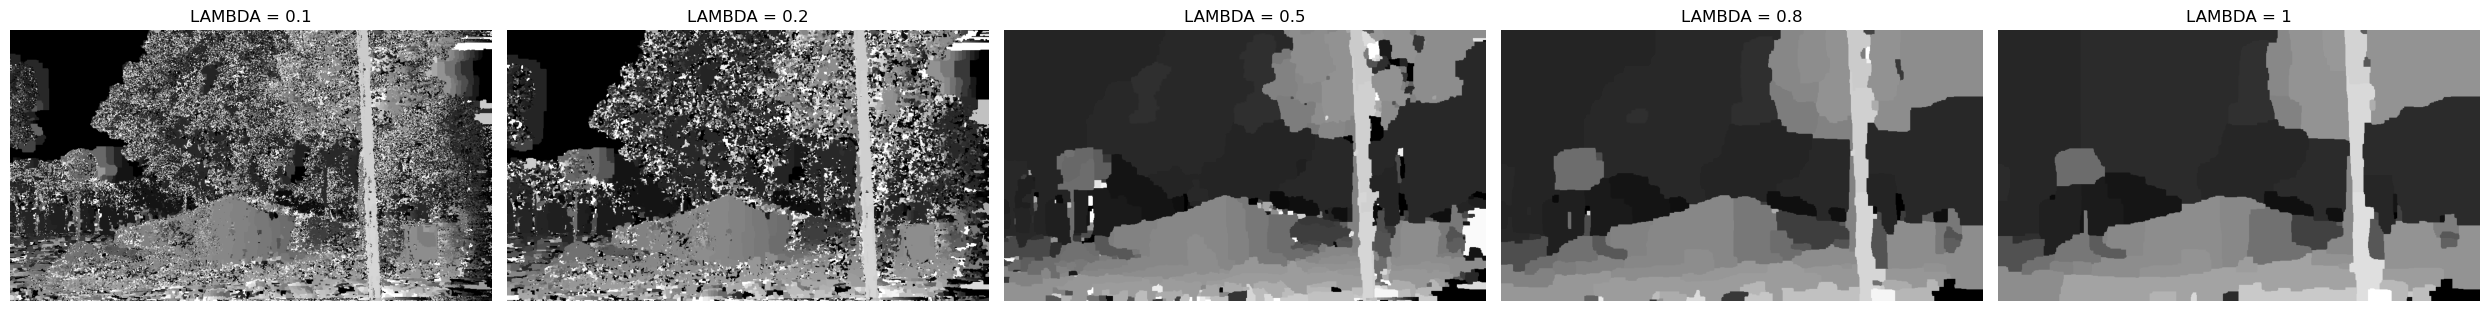

In [37]:
# Try different values of LAMBDA
LAMBDA_s =[0.1, 0.2, 0.5, 0.8, 1]

num_cols = len(LAMBDA_s)
fig, axes = plt.subplots(1, num_cols, figsize=(5*num_cols, 5))

for i, LAMBDA in enumerate(LAMBDA_s):
    labels = pygco.cut_grid_graph_simple(data_term, LAMBDA * prior_matrix, n_iter=-1, algorithm='swap')
    labels = labels.reshape(h1, w1)

    ax = axes[i]
    ax.imshow(labels, cmap='gray')
    ax.set_title(f'LAMBDA = {LAMBDA}')
    ax.axis('off')

plt.tight_layout()
plt.show()

3. Show your best result, and provide some discussion if necessary (particularly if the results are not as good as expected).

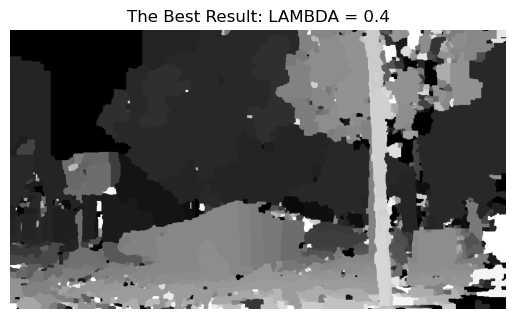

In [38]:
LAMBDA = 0.4
labels = pygco.cut_grid_graph_simple(data_term, LAMBDA * prior_matrix, n_iter=-1, algorithm= 'swap')
labels = labels.reshape(h1, w1)

plt.imshow(labels, cmap='gray')
plt.title(f'The Best Result: LAMBDA = {LAMBDA}')
plt.axis('off')
plt.show()

### Discussion:
1. As the value of λ increases, the smoothing effect of the prior term becomes more pronounced, leading to a reduction in noise within the depth map. However, this reduction comes at the expense of finer details.

2. When computing a depth map based on an unrectified image, the careful selection of appropriate disparity candidates is crucial and can significantly impact the accurate representation of the depth map.

3. Utilizing only two images for depth map computation yields limited information, resulting in less-than-ideal performance of the depth map.